In [1]:
# pip install pytorchvideo

In [55]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
# from pytorchvideo.models.hub import slowfast_r50
from torchvision import transforms

In [6]:
files = ['non_shop_lifters', 'shop_lifters']
data_path = '/kaggle/input/edited-shop-dataset/Edited_Shop_Dataset'

In [7]:
videos = []
labels = []
for file in files:
    videos_file = os.path.join(data_path, file)
    for data_file in os.listdir(videos_file):
        video_file = os.path.join(videos_file, data_file)
        videos.append(video_file)
        labels.append(1 if file == 'shop_lifters' else 0)

In [8]:
files_train, files_val_test, labels_train, labels_val_test = train_test_split(
    videos, labels, test_size = 0.35, random_state = 42) 

files_val, files_test, labels_val, labels_test = train_test_split(
    files_val_test, labels_val_test, test_size = 0.5, random_state = 42) 

In [9]:
print(len(files_train))
print(len(files_val))
print(len(files_test))

555
150
150


In [10]:
def load_video_frames(path):
    cap = cv2.VideoCapture(path)
    frames = []
    count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame / 255.0  
        frames.append(frame)
    cap.release()
    return np.array(frames)  # Shape: (num_frames, height, width, channels)
# img = load_video_frames('/kaggle/input/edited-shop-dataset/Edited_Shop_Dataset/non_shop_lifters/video_0.mp4')
# print(img.shape)
# plt.imshow(img[0])
# plt.axis('off')  # hide axes
# plt.title("My Image")
# plt.show()

In [8]:
# class PackPathway(torch.nn.Module):
#     def __init__(self, alpha: int = 4):
#         super().__init__()
#         self.alpha = alpha

#     def forward(self, frames: torch.Tensor):
#         fast_pathway = frames
#         slow_pathway = frames[:, ::self.alpha, :, :]
#         return [slow_pathway, fast_pathway]

In [9]:
# import math 

# class PackPathway(torch.nn.Module):
#     def __init__(self, alpha: int = 4):
#         super().__init__()
#         self.alpha = alpha

#     def forward(self, frames: torch.Tensor):
#         # frames shape: (C, T, H, W)
#         fast_pathway = frames  # All frames

#         # Subsample temporal dimension (dim=1)
#         slow_pathway = torch.index_select(
#             frames, 1, torch.linspace(
#                 0, frames.shape[1] - 1, math.ceil(frames.shape[1] / self.alpha)
#             ).long()
#         )
#         return [slow_pathway, fast_pathway]

In [10]:
# class VideoNormalize(torch.nn.Module):
#     def __init__(self, mean, std):
#         super().__init__()
#         self.mean = torch.tensor(mean).view(3, 1, 1, 1)
#         # tensor([
#         #   [[0.5]],
#         #   [[0.4]],
#         #   [[0.3]]
#         # ])
#         self.std = torch.tensor(std).view(3, 1, 1, 1)

#     def forward(self, video):
#         # video: (C, T, H, W)
#         return (video - self.mean.to(video.device)) / self.std.to(video.device)

In [11]:
class Video_dataset(Dataset): # using Dataset 
                              # will allow PyTorch to load and batch the video data.
    def __init__(self, video_paths, labels):
        self.video_paths = video_paths
        self.labels = labels
        # self.transform = VideoNormalize([0.45, 0.45, 0.45], [0.225, 0.225, 0.225]) 
        # self.pack_pathway = PackPathway(alpha=4)  # slow gets 1/4 frames

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, index): # PyTorch calls this every time it needs one sample 
                                  # You pass an index, and it returns the video and its label at that index.
        video_path = self.video_paths[index]
        label = self.labels[index]

        video_numpy = load_video_frames(video_path) # Shape: (num_frames, height, width, channels)
        video_tensor = torch.tensor(video_numpy, dtype=torch.float32)
        # video_tensor = video_tensor.permute(0, 3, 1, 2) # (num_frames, channels, height, width) From scratch model
        video_tensor = video_tensor.permute(3, 0, 1, 2) # (channels, num_frames, height, width) pretrained model
        
        # if self.transform:
        #     video_tensor = self.transform(video_tensor)
        # video_tensor = self.pack_pathway(video_tensor) # converts to [slow, fast] list

        return video_tensor, torch.tensor(label, dtype=torch.float32).unsqueeze(0)
        # Converts the video and label into PyTorch tensors so they can be fed into a model.
        # You may need to use .permute(0, 3, 1, 2) on video_tensor if your model expects channel-first: (frames, channels, height, width).

In [12]:
train_dataset = Video_dataset(files_train, labels_train)
val_dataset = Video_dataset(files_val, labels_val)
test_dataset = Video_dataset(files_test, labels_test)

In [13]:
# def pack_pathway_output(frames):
#     """
#     Takes a video tensor [B, C, T, H, W]
#     Returns: [slow_pathway, fast_pathway]
#     """
#     # Fast pathway = original
#     fast_pathway = frames

#     # Slow pathway = sample fewer frames
#     # Typically: alpha = 4 → take every 4th frame
#     slow_pathway = frames[:, :, ::4, :, :]  # temporal downsampling

#     return [slow_pathway, fast_pathway]

In [13]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle = False) 

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class ResNet34FeatureExtractor(nn.Module):
    def __init__(self):
        super(ResNet34FeatureExtractor, self).__init__()
        resnet = models.resnet34(weights=None)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        #  [
        #  conv1,        # 7x7 Conv, stride=2, padding=3  (B, 64, 112, 112)
        #  bn1,          # batch norm  (B, 64, 112, 112)
        #  relu,         # activation  (B, 64, 112, 112)
        #  maxpool,      # downsampling  (B, 64, 56, 56)
        #  layer1,       resnet Block(  conv1 -> BatchNorm -> ReLU -> conv2 -> BatchNorm +     
                                     #  skip connection (identity) -> ReLU ) (B, 64, 56, 56)
        #  layer2,       # resnet Block 2  (B, 128, 28, 28)
        #  layer3,       # resnetBlock 3   (B, 256, 14, 14)
        #  layer4,       # resnetBlock 4   (B, 512, 7, 7)
        #  avgpool,      # global average pooling 
                         # returns the mean of all 49 values, (B, 512, 1, 1)
        #  fc            # removed
        # ] 

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.shape # (4, 70, 3, 224, 224)
        x = x.view(batch_size * seq_len, C, H, W) # (4*70, 3, 224, 224)
        features = self.feature_extractor(x) # (4*70, 512, 1, 1)
        features = features.view(batch_size, seq_len, -1) # (4, 70, 512*1*1)
        return features


class CNN_LSTM(nn.Module):
    def __init__(self, hidden_dim=256, num_layers=2, num_classes=1):
        super(CNN_LSTM, self).__init__()
        self.cnn = ResNet34FeatureExtractor() # (4, 70, 512)
        self.lstm = nn.LSTM(input_size=512, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
    def forward(self, x):
        features = self.cnn(x)
        lstm_out, _ = self.lstm(features)
        last_frame_features = lstm_out[:, -1, :]
        out = self.fc(last_frame_features)
        return out

In [15]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy over Epochs')
    plt.show()

In [47]:
def train_model(model, train_loader, val_loader, lr, epochs, i3d_model=None):
    LCE = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    best_val_acc = 0.0


    for epoch in range(epochs):
        model.train()
        train_loss, train_correct, total = 0.0, 0, 0

        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            output = model(x_batch)
            if i3d_model:
                output = torch.mean(output, dim=2)
            loss = LCE(output, y_batch)
            loss.backward()
            optimizer.step()

            predicted = (torch.sigmoid(output) > 0.5).float()
            train_correct += (predicted == y_batch).sum().item()
            train_loss += loss.item() * x_batch.size(0)
            total += y_batch.size(0)

        train_loss /= total
        train_correct /= total
        train_losses.append(train_loss)
        train_accuracies.append(train_correct)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                if i3d_model:
                    outputs = torch.mean(outputs, dim=2)
                loss = LCE(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_losses.append(val_loss / val_total)
        val_accuracies.append(val_correct / val_total)
        if val_correct / val_total > best_val_acc:
            best_val_acc = val_correct / val_total
            torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    print("\n")
    return train_losses, val_losses, train_accuracies, val_accuracies


Epoch 1/12, Train Loss: 0.4465, Train Acc: 0.8198, Val Loss: 0.3643, Val Acc: 0.8800
Epoch 2/12, Train Loss: 0.3814, Train Acc: 0.8450, Val Loss: 0.4000, Val Acc: 0.8133
Epoch 3/12, Train Loss: 0.2985, Train Acc: 0.8847, Val Loss: 0.1565, Val Acc: 0.9400
Epoch 4/12, Train Loss: 0.2167, Train Acc: 0.9333, Val Loss: 0.7163, Val Acc: 0.7067
Epoch 5/12, Train Loss: 0.2517, Train Acc: 0.9225, Val Loss: 0.0780, Val Acc: 0.9933
Epoch 6/12, Train Loss: 0.2049, Train Acc: 0.9423, Val Loss: 0.2258, Val Acc: 0.9933
Epoch 7/12, Train Loss: 0.1275, Train Acc: 0.9658, Val Loss: 0.0417, Val Acc: 0.9933
Epoch 8/12, Train Loss: 0.1372, Train Acc: 0.9604, Val Loss: 0.0404, Val Acc: 0.9933
Epoch 9/12, Train Loss: 0.1183, Train Acc: 0.9622, Val Loss: 0.0519, Val Acc: 0.9800
Epoch 10/12, Train Loss: 0.1013, Train Acc: 0.9712, Val Loss: 0.5092, Val Acc: 0.8600
Epoch 11/12, Train Loss: 0.0898, Train Acc: 0.9712, Val Loss: 0.0385, Val Acc: 0.9933
Epoch 12/12, Train Loss: 0.1278, Train Acc: 0.9640, Val Loss: 0

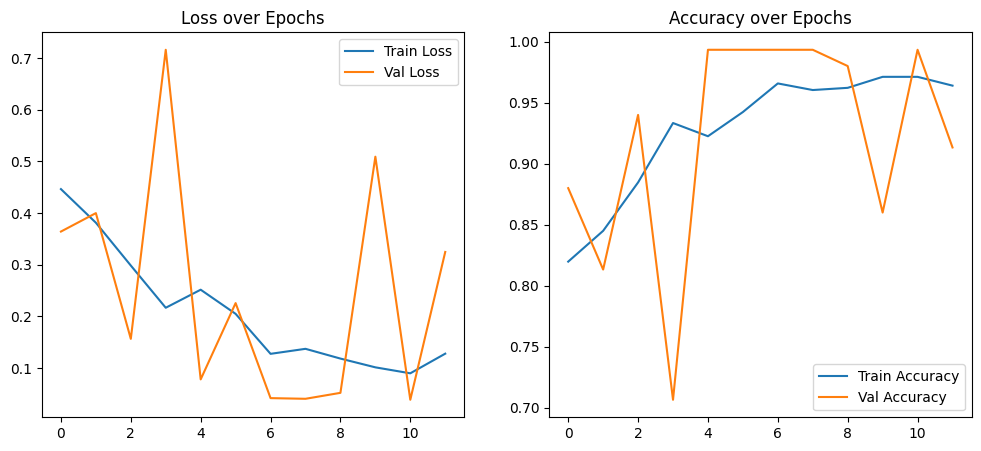

In [20]:
model = CNN_LSTM().to(device)
model.load_state_dict(torch.load("/kaggle/input/cnn-lstm-weights/best_model.pth"))
train_loss, val_loss, train_acc, val_acc = train_model(model, train_loader, val_loader, 0.001, epochs=12)
plot_metrics(train_loss, val_loss, train_acc, val_acc)

In [21]:
model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))

<All keys matched successfully>

In [61]:
def evaluate(model, loader, i3d_model=None):
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            if i3d_model:
                outputs = torch.mean(outputs, dim=2)
            preds = (torch.sigmoid(outputs) > 0.5 ).float() 
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            all_preds.append(preds.view(-1).cpu())   # y_true → shape: [N]     (1D vector)
            all_labels.append(labels.view(-1).cpu()) # y_pred → shape: [N]
                                                     # as metrics like precision, recall, F1, and IoU from sklearn.metrics expect

    y_pred = torch.cat(all_preds).numpy()  # Combine predictions across all batches
    y_true = torch.cat(all_labels).numpy() # Required because sklearn needs NumPy arrays

    precision = precision_score(y_true, y_pred, pos_label=1) # Of all predicted water pixels, how many were correct?
    recall    = recall_score(y_true, y_pred, pos_label=1) # Of all actual water pixels, how many did the model find?
    f1        = f1_score(y_true, y_pred, pos_label=1)  # Harmonic mean of precision & recall (balance)

    print("Evaluation Metrics:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"Test Accuracy: {correct / total:.4f}")
    
    return correct / total

In [22]:
test_acc = evaluate(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9800


In [1]:
!git clone https://github.com/piergiaj/pytorch-i3d.git
%cd pytorch-i3d
!pip install -r requirements.txt

Cloning into 'pytorch-i3d'...
remote: Enumerating objects: 21, done.
remote: Total 21 (delta 0), reused 0 (delta 0), pack-reused 21 (from 1)
Receiving objects: 100% (21/21), 178.18 MiB | 39.47 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (12/12), done.
/kaggle/working/pytorch-i3d
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


> # I3D Architecture: Layer-by-Layer

| Layer Name         | Description                                   | Output Shape (Example)      |
| ------------------ | --------------------------------------------- | --------------------------- |
| Conv3d\_1a\_7x7    | 7x7x7 3D conv, stride=2                       | `[N, 64, T/2, 112, 112]`    |
| MaxPool3d\_2a\_3x3 | 3D max pool, stride=2                         | `[N, 64, T/4, 56, 56]`      |
| Conv3d\_2b\_1x1    | 1x1x1 conv                                    | `[N, 64, T/4, 56, 56]`      |
| Conv3d\_2c\_3x3    | 3x3x3 conv                                    | `[N, 192, T/4, 56, 56]`     |
| MaxPool3d\_3a\_3x3 | 3D max pool                                   | `[N, 192, T/8, 28, 28]`     |
| Inception modules  | Series of Inception blocks (3b, 4a–4e, 5a–5b) | Gradually reduce resolution |
| AvgPool3d\_5a\_2x2 | Global average pool                           | `[N, 1024, 1, 1, 1]`        |
| Dropout            | 50% dropout                                   | `[N, 1024, 1, 1, 1]`        |
| Conv3d\_0c\_1x1    | Final 1x1x1 conv (logits)                     | `[N, num_classes, 1, 1, 1]` |
| Squeeze            | Remove singleton dims                         | `[N, num_classes]`          |


**Input**
* Video tensor of shape [N, 3, T, 224, 224]

> # The Dataset I3D Was Pretrained On


* Kinetics-400 (or Kinetics-600, Kinetics-700) developed by DeepMind
* Used to pretrain the original I3D model.
* Contains 400 (or more) human action categories.
* Each category has hundreds of short clips, about 10 seconds long.

> **Some examples of the 400 action labels:** 


* drinking
* waving hand
* jumping
* kicking
* putting something in pocket
* taking something from a shelf
* tying shoelaces
* sneezing


In [38]:
from pytorch_i3d import InceptionI3d


i3d = InceptionI3d(400, in_channels=3)
i3d.load_state_dict(torch.load('models/rgb_imagenet.pt')) 
i3d.replace_logits(1)

In [39]:
children = list(i3d.children())

for layer in children[:17]:
    for param in layer.parameters():
        param.requires_grad = False

for layer in children[17:]:
    for param in layer.parameters():
        param.requires_grad = True

Epoch 1/12, Train Loss: 0.1529, Train Acc: 0.9532, Val Loss: 0.0855, Val Acc: 0.9667
Epoch 2/12, Train Loss: 0.0790, Train Acc: 0.9874, Val Loss: 0.1363, Val Acc: 0.9600
Epoch 3/12, Train Loss: 0.0685, Train Acc: 0.9892, Val Loss: 0.0311, Val Acc: 0.9933
Epoch 4/12, Train Loss: 0.0674, Train Acc: 0.9874, Val Loss: 0.0387, Val Acc: 0.9933
Epoch 5/12, Train Loss: 0.0521, Train Acc: 0.9874, Val Loss: 0.0209, Val Acc: 1.0000
Epoch 6/12, Train Loss: 0.0265, Train Acc: 1.0000, Val Loss: 0.0170, Val Acc: 1.0000
Epoch 7/12, Train Loss: 0.0411, Train Acc: 0.9874, Val Loss: 0.0101, Val Acc: 1.0000
Epoch 8/12, Train Loss: 0.0211, Train Acc: 1.0000, Val Loss: 0.0080, Val Acc: 1.0000
Epoch 9/12, Train Loss: 0.0259, Train Acc: 0.9982, Val Loss: 0.0127, Val Acc: 1.0000
Epoch 10/12, Train Loss: 0.0159, Train Acc: 1.0000, Val Loss: 0.0147, Val Acc: 0.9933
Epoch 11/12, Train Loss: 0.0155, Train Acc: 1.0000, Val Loss: 0.0077, Val Acc: 1.0000
Epoch 12/12, Train Loss: 0.0103, Train Acc: 1.0000, Val Loss: 0

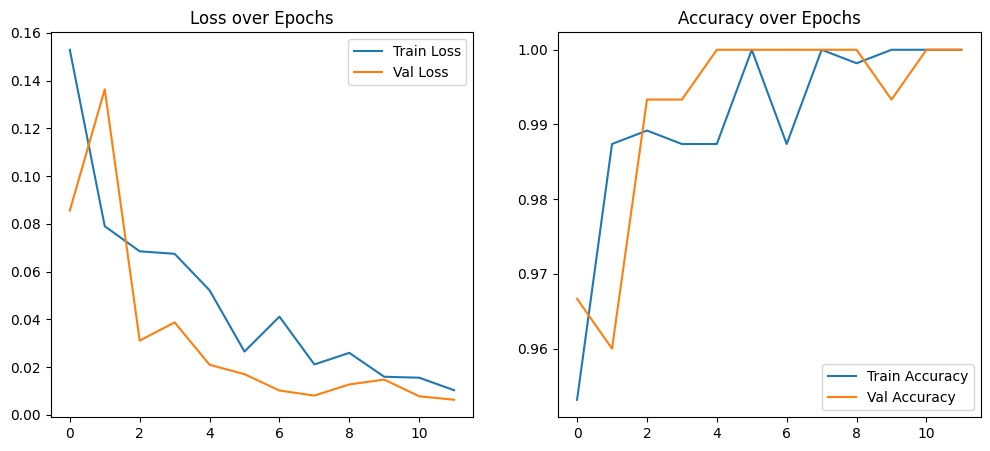

In [48]:
i3d = i3d.to(device)
train_loss, val_loss, train_acc, val_acc = train_model(i3d, train_loader, val_loader, 0.001, epochs=12, i3d_model= True)
plot_metrics(train_loss, val_loss, train_acc, val_acc)

In [49]:
i3d.load_state_dict(torch.load("/kaggle/working/best_model.pth"))

<All keys matched successfully>

In [62]:
test_acc = evaluate(i3d, test_loader, i3d_model=True)

Evaluation Metrics:
Precision: 1.0000
Recall   : 1.0000
F1-score : 1.0000
Test Accuracy: 1.0000
